# Chigira Simulation Example 1
This notebook contains the code that generates the results that is shown in the main Chigira example article titled "Principal Component Analysis and Cointegration" on the documentation site.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

In [2]:
import warnings
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VAR
from statsad import ChigiraCointTest

Correct rank: 1


,T,Johansen,Chigira
0,30,1116,2501
1,50,2320,4531
2,100,3550,9377
3,200,7964,9264
4,400,8977,9179


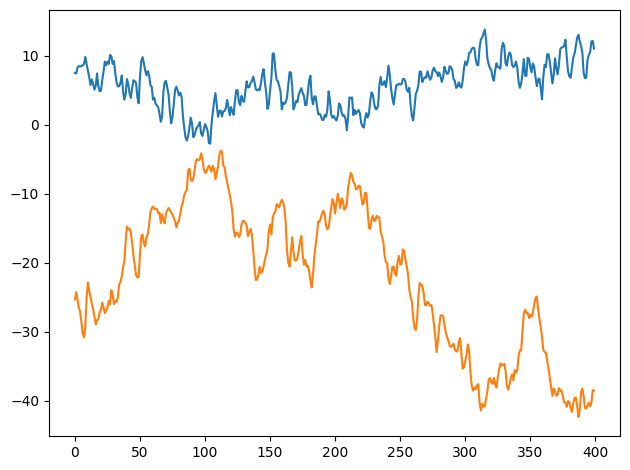

In [3]:
series_len = [30,50,100,200,400] # specify the series length T
k_ar_vals = [1,1,3,4,5] # number of lags in Johansen per each length T
n_jo, n_chi = [0]*len(k_ar_vals), [0]*len(k_ar_vals)
nSim = 10000
chigira_test = ChigiraCointTest(spec='c')
# set coefficients for y_t
alpha = np.array([[-1],[0]])
beta_trans = np.array([[0.4, 0.1]])
ar_coeff = alpha.dot(beta_trans)
coeff_trans = ar_coeff.T+np.identity(2)
coeff_rnk = np.linalg.matrix_rank(ar_coeff) # expect the rank to be 1
print('Correct rank:', coeff_rnk)
# create a multivariate normal distribution object
nrv = multivariate_normal(mean=[0,0], cov=np.identity(2), seed=100)
for iSim in range(nSim):
    # draw random error. need extra one for the first epsilon
    u_t = nrv.rvs(size=series_len[-1]+101) # burn off the first 100 so the series don't all start at the same point

    # epsilon_t = 0.5 * u_{t-1} + u_t
    eps_t = 0.5*u_t[:-1,:] + u_t[1:,:]

    # build the y series
    y_prev = np.array([[0, 0]])
    y_t = np.zeros([eps_t.shape[0],2])
    for t in range(eps_t.shape[0]):
        y_prev = y_t[[t],:] = y_prev.dot(coeff_trans) + eps_t[t]
    y_t = y_t[100:,]

    if iSim == 0:
        fig, ax = plt.subplots(1,1)
        ax.plot(y_t)
        fig.tight_layout()
        fig.savefig('../docs/source/img/chigira_exp1_two_series.png',transparent=False, facecolor='white')

    # loop through each series length
    for ilen in range(len(series_len)):
        crnt_len = series_len[ilen]
        # run the Johansen test
        jo_rst = coint_johansen(y_t[:crnt_len], det_order=0, k_ar_diff=k_ar_vals[ilen])
        n_coint = 0 # denotes the number of cointegration vectors
        for i in range(2):
            if jo_rst.max_eig_stat[i] < jo_rst.max_eig_stat_crit_vals[i, 2]:
                break
            n_coint += 1 # tally the number of cointegration vectors

        if n_coint == coeff_rnk:
            n_jo[ilen] += 1 # tally the number of correct simulations from Johansen

        # run the chigira test
        if chigira_test.fit_test(y_t[:crnt_len], sig=0.01) == coeff_rnk:
            n_chi[ilen] += 1 # tally the number of correct simulations from Chigira
pd.DataFrame({'T':series_len, 'Johansen':n_jo, 'Chigira':n_chi})   

\begin{equation}
    
\end{equation}